### ***Importing Libraries that i will be using for this model***

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

### ***Changing the environment CPU to GPU (Check the GPU Environment) Because the model is too big to train on cpu it will take alot of time***

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce GTX 1080


### ***Transformaing the data so it fits the model's requirements which is (Resnet18) and agumenting the training data only***

In [3]:
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

### ***Loading (train/test/validation) datasets from local files***

In [4]:

train_ds = datasets.ImageFolder(root='SICPROJECT_801010/train', transform=train_tfms)
val_ds   = datasets.ImageFolder(root='SICPROJECT_801010/val',   transform=val_test_tfms)
test_ds  = datasets.ImageFolder(root='SICPROJECT_801010/test',  transform=val_test_tfms)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

print("Train size:", len(train_ds))
print("Val size  :", len(val_ds))
print("Test size :", len(test_ds))
print("Classes   :", train_ds.classes)
print(train_ds.class_to_idx)

Train size: 4684
Val size  : 585
Test size : 587
Classes   : ['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


In [5]:
labels = torch.tensor([y for _, y in train_ds.samples])
counts = torch.bincount(labels)

print("Class counts:", counts)  

class_weights = (len(train_ds) / (2 * counts.float())).to(device)
print("Class weights:", class_weights)

Class counts: tensor([1266, 3418])
Class weights: tensor([1.8499, 0.6852], device='cuda:0')


### ***The function that is used evaluate the model*** 

In [6]:
def evaluate(model, dataloader, device, split_name="SPLIT"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for img, label in dataloader:
            img = img.to(device)
            label = label.to(device)

            logits = model(img)                 
            preds = logits.argmax(dim=1)        # pick class with highest score

            all_preds.append(preds.cpu())
            all_labels.append(label.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec  = recall_score(all_labels, all_preds, zero_division=0)
    f1   = f1_score(all_labels, all_preds, zero_division=0)
    cm   = confusion_matrix(all_labels, all_preds)

    print(f"\n{split_name} METRICS:")
    print(f"Accuracy : {acc}")
    print(f"Precision: {prec}")
    print(f"Recall   : {rec}")
    print(f"F1 Score : {f1}")
    print("Confusion matrix:\n", cm)

    return acc, prec, rec, f1, cm


### ***Loading the model and freezing and unfreezing the needed layers for fine tuning***

In [7]:
model = models.resnet18(weights="DEFAULT")


for p in model.parameters():
    p.requires_grad = False

# Replace classifier (fc) with 2-class layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)

#  unfreeze last block (layer4) + fc for fine-tuning
for name, p in model.named_parameters():
    if "layer4" in name or "fc" in name:
        p.requires_grad = True


model = model.to(device)
lossfun = nn.CrossEntropyLoss()


trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_params, lr=1e-3)


print("Trainable parameter count:",
      sum(p.numel() for p in trainable_params))

Trainable parameter count: 8394754


### ***Model Training***

In [8]:
epochs = 6

train_losses = []
train_accuracies = []
val_acc_history = []  
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for img, label in train_dl:
        img = img.to(device)
        label = label.to(device)

        
        logits = model(img)                
        loss = lossfun(logits, label)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # track loss & accuracy
        running_loss += loss.item() * img.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == label).sum().item()
        total += label.size(0)

    epoch_loss = running_loss / len(train_ds)
    epoch_acc  = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} - Train loss: {epoch_loss:.4f}, Train acc: {epoch_acc:.4f}")

    # validation each epoch
    val_acc, val_prec, val_rec, val_f1, val_cm = evaluate(model, val_dl, device, split_name=f"VAL (epoch {epoch+1})")
    val_acc_history.append(val_acc)
# final eval
evaluate(model, train_dl, device, split_name="TRAIN (final)")
acc_test, prec_test, rec_test, f1_test, cm_test = evaluate(model, test_dl,  device, split_name="TEST (final)")


Epoch 1/6 - Train loss: 0.1678, Train acc: 0.9353

VAL (epoch 1) METRICS:
Accuracy : 0.9777777777777777
Precision: 0.9882075471698113
Recall   : 0.9812646370023419
F1 Score : 0.9847238542890717
Confusion matrix:
 [[153   5]
 [  8 419]]
Epoch 2/6 - Train loss: 0.1165, Train acc: 0.9560

VAL (epoch 2) METRICS:
Accuracy : 0.9606837606837607
Precision: 0.9879227053140096
Recall   : 0.9578454332552693
F1 Score : 0.9726516052318668
Confusion matrix:
 [[153   5]
 [ 18 409]]
Epoch 3/6 - Train loss: 0.0947, Train acc: 0.9637

VAL (epoch 3) METRICS:
Accuracy : 0.9692307692307692
Precision: 0.9880668257756563
Recall   : 0.9695550351288056
F1 Score : 0.9787234042553191
Confusion matrix:
 [[153   5]
 [ 13 414]]
Epoch 4/6 - Train loss: 0.0843, Train acc: 0.9682

VAL (epoch 4) METRICS:
Accuracy : 0.9743589743589743
Precision: 0.9904761904761905
Recall   : 0.9742388758782201
F1 Score : 0.9822904368358913
Confusion matrix:
 [[154   4]
 [ 11 416]]
Epoch 5/6 - Train loss: 0.0842, Train acc: 0.9678

VAL (

### ***Final Results***

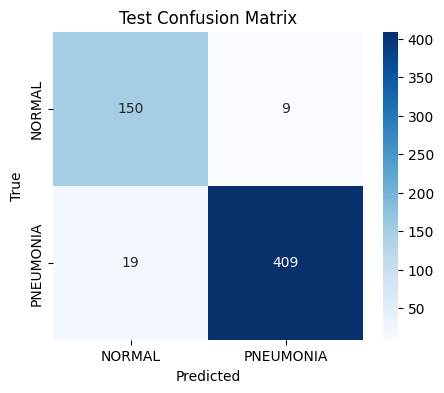

In [14]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_test,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=train_ds.classes,
            yticklabels=train_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix")
plt.show()

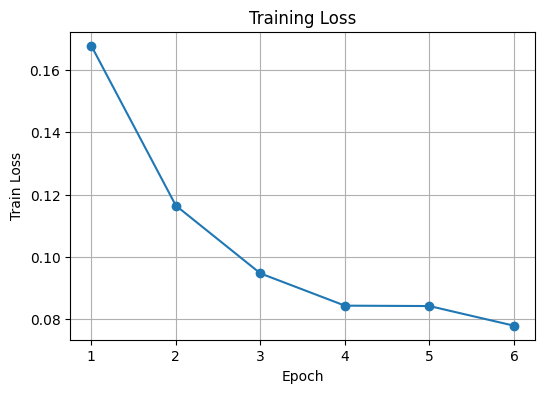

In [13]:
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()


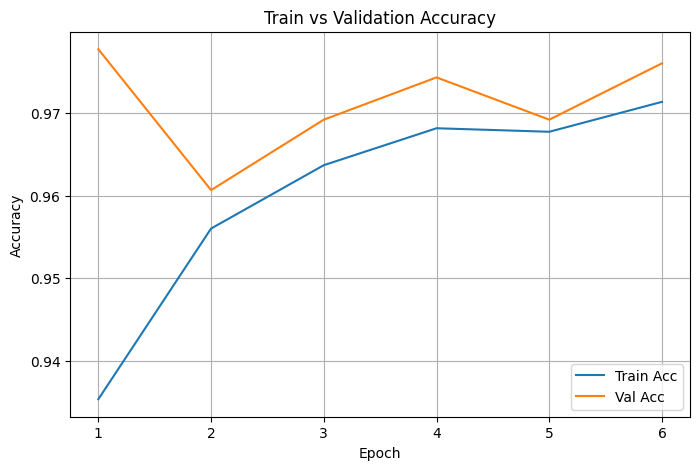

In [12]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_accuracies, label="Train Acc")
plt.plot(epochs_range, val_acc_history, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()